In [8]:
import numpy as np
import os
from matplotlib import pyplot as plt
from astropy.io import fits
# from astropy import stats
# import shutil
from astropy.visualization import simple_norm

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.ndimage import shift
from matplotlib.colors import LogNorm

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astroquery.ned import Ned
import astropy.units as u
from astropy.nddata import Cutout2D
# import pylab as plt
from scipy import interpolate
from matplotlib.colors import ListedColormap
# import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
# from pyBBarolo import *
from scipy import stats

In [9]:
# Filling NaN pixels with the values of pixels located symmetrically relative to the major axis.
# It is a necessary procedure if we want to obtain reliable results from the Barolo application.

def fill_nans(fits_file=None,galname=None,cvel=None,savefits=False,show_plot=False):
    
    RA = Ned.query_object(galname)['RA']
    DEC = Ned.query_object(galname)['DEC']
    print(RA, DEC)

    cposition = SkyCoord('{} {}'.format(RA[0],DEC[0]), frame='fk5', unit='deg', equinox='J2000.0')
    data =  WCS(fits_file, naxis = 2)

    print(cposition)
    y0_,x0_ = skycoord_to_pixel(cposition,data) #find central pixel
    y0_,x0_ = int(y0_),int(x0_)
    
    maps = fits.getdata(fits_file)
    maps_ = np.squeeze(maps)
    maps = maps_-cvel
    maps = maps.T
    X,Y = np.meshgrid(np.arange(0,maps.shape[1], 1), np.arange(0,maps.shape[0], 1))

    R_max = np.min([x0_,maps.shape[1]-x0_,y0_,maps.shape[0]-y0_])
    nan_map = np.isnan(maps) & (np.abs(X-x0_) < R_max) & (np.abs(Y-y0_) < R_max)

    nan_X = X[nan_map]
    nan_Y = Y[nan_map]

    maps_new = maps*1.0
    maps_new[nan_Y, nan_X] = - maps[2*y0_-nan_Y,2*x0_-nan_X]

    if show_plot:
        fig = plt.figure(figsize=[21,9])
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        X, Y = np.meshgrid(np.arange(0, maps.shape[1], 1), np.arange(0, maps.shape[0], 1))    

        plt.subplot(1,2,1) 
        plt.title(r'$V_{obs}$', fontsize=35, pad=20)
        quadmesh = plt.pcolormesh(X,Y, maps, cmap='coolwarm')
        quadmesh.set_clim(vmin=-150,vmax=150)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
        plt.colorbar()

        plt.subplot(1,2,2) 
        plt.title(r'$V_{obs}$ fill Nan', fontsize=35, pad=20)
        quadmesh = plt.pcolormesh(X,Y, maps_new, cmap='coolwarm')
        # quadmesh = plt.pcolormesh(X,Y, maps_new.T, cmap='coolwarm')
        quadmesh.set_clim(vmin=-150,vmax=150)
        plt.tick_params(bottom=False,labelbottom=False,left=False,labelleft=False)
        plt.colorbar()
    
    if savefits:
        
        data = fits.open(fits_file)
        header = data[0].header
        fits_new = fits.PrimaryHDU(data=np.array(maps_new.T+cvel),header=header)
        fits_new.writeto(fits_file.replace('.fits','_notnan.fits'),overwrite=True)
    

    RA    
 degrees  
----------
  65.00164    DEC    
 degrees  
----------
 -54.93794
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (65.00164, -54.93794)>


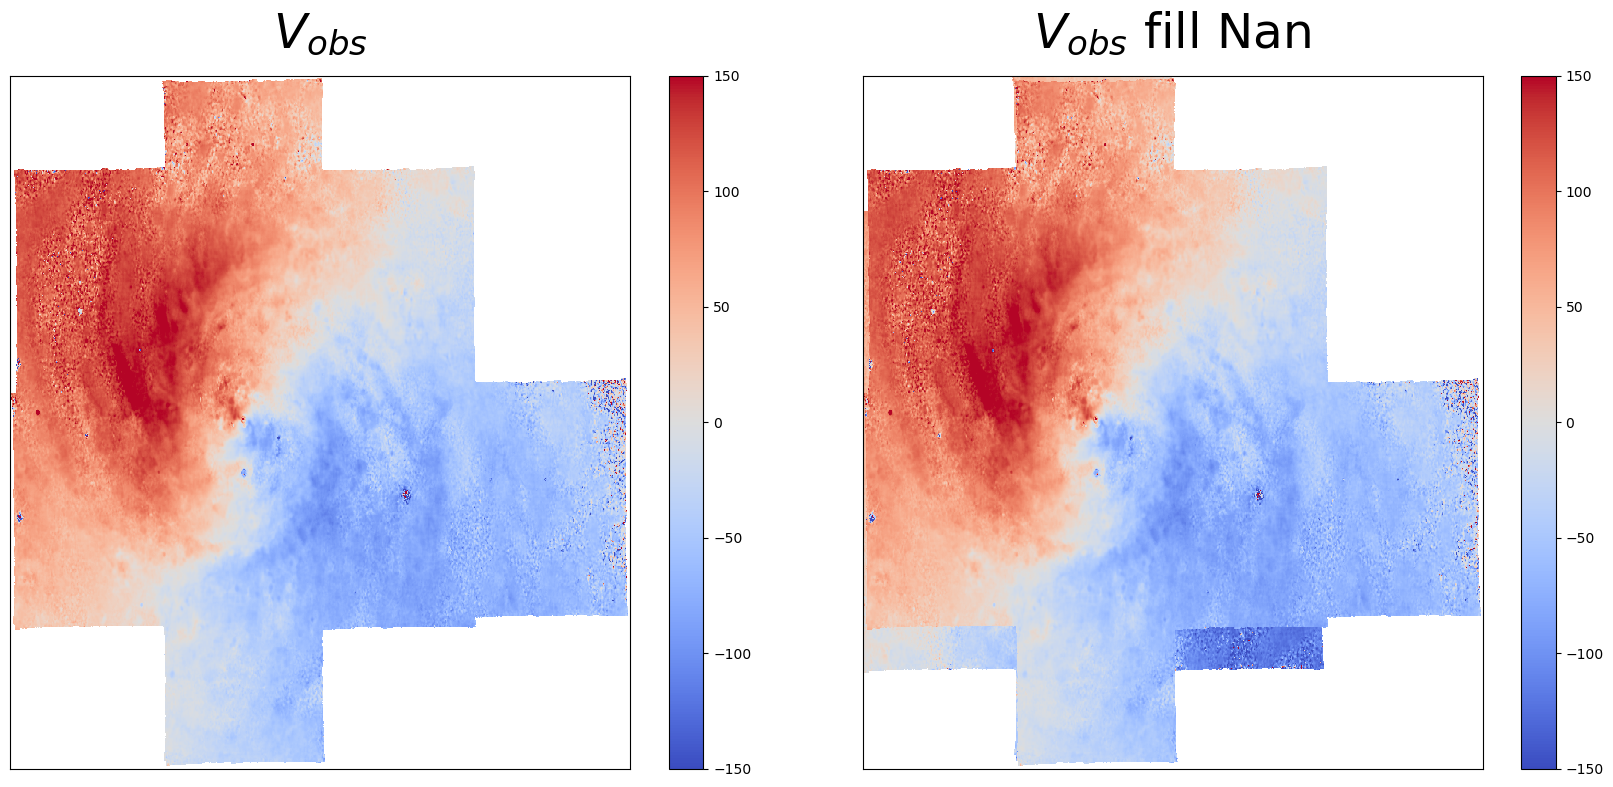

In [10]:
fill_nans(fits_file='./data/NGC1566_vel_Ha.fits',cvel = 0, galname='NGC1566',savefits=True,show_plot=True)

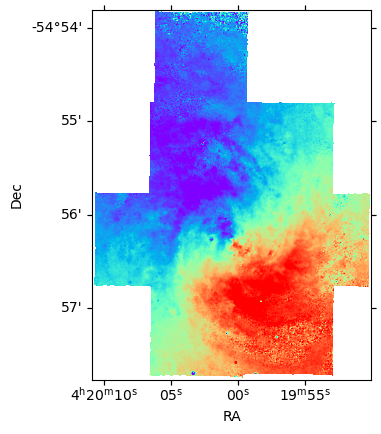

In [11]:
import warnings
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('./data/NGC1566_vel_Ha.fits')

hdu = fits.open(filename)[0]
with warnings.catch_warnings():
    # Ignore a warning on using DATE-OBS in place of MJD-OBS
    warnings.filterwarnings('ignore', message="'datfix' made the change",
                            category=FITSFixedWarning)
    wcs = WCS(hdu.header)

fig = plt.figure()
fig.add_subplot(111, projection=wcs)
norm = simple_norm(hdu.data, "linear", percent=95)
plt.imshow(hdu.data, cmap="rainbow", origin="lower", norm=norm)
# plt.imshow(hdu.data, origin='lower', cmap="rainbow", norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')

In [12]:
wcs_coord = np.empty(shape=(hdu.data.shape[0],hdu.data.shape[1], 2))
print(wcs_coord.shape)

(1187, 898, 2)


In [13]:

print(wcs.pixel_to_world(30, 40))

<SkyCoord (ICRS): (ra, dec) in deg
    (65.0425075, -54.96047854)>


In [14]:
for i in range(wcs_coord.shape[0]):
    for j in range(wcs_coord.shape[1]):
        wcs_coord[i, j] = wcs.wcs_pix2world(i, j, 1)
        

In [15]:
wcs_coord.shape

(1187, 898, 2)

In [16]:
wcs_coord[:,:,0]

array([[65.04550962, 65.04550956, 65.0455095 , ..., 65.04545566,
        65.0454556 , 65.04545554],
       [65.04541285, 65.04541279, 65.04541273, ..., 65.04535901,
        65.04535895, 65.04535889],
       [65.04531608, 65.04531602, 65.04531596, ..., 65.04526236,
        65.04526231, 65.04526225],
       ...,
       [64.93093594, 64.93093604, 64.93093613, ..., 64.93102357,
        64.93102366, 64.93102376],
       [64.93083917, 64.93083927, 64.93083937, ..., 64.93092692,
        64.93092701, 64.93092711],
       [64.9307424 , 64.9307425 , 64.9307426 , ..., 64.93083027,
        64.93083037, 64.93083046]])

In [19]:
print(wcs_coord.shape)
galname = "NGC1566"
# RA = np.asarray(Ned.query_object(galname)['RA'])
# DEC = np.asarray(Ned.query_object(galname)['DEC'])

RA0, DEC0 = wcs.wcs_pix2world(hdu.header["CRPIX1"], hdu.header["CRPIX2"], 1)
print(RA0, DEC0)
# print(RA, DEC)

(1187, 898, 2)
65.001846393711 -54.93791205151501


C:\Users\kpoli\AppData\Local\Temp\ipykernel_9628\320712562.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(3600*(wcs_coord[:,:,0]-RA0), 3600*(wcs_coord[:,:,1]-DEC0), hdu.data)


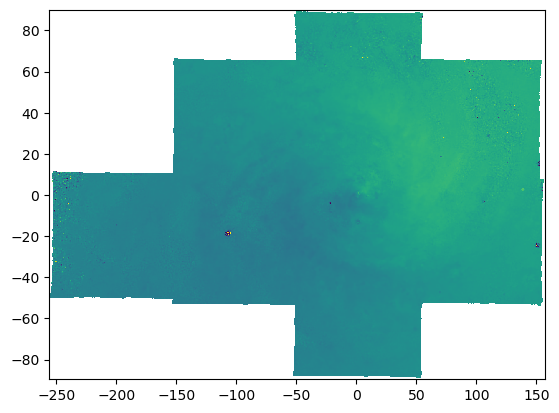

In [20]:
plt.close()
plt.pcolormesh(3600*(wcs_coord[:,:,0]-RA0), 3600*(wcs_coord[:,:,1]-DEC0), hdu.data)
plt.show()

C:\Users\kpoli\AppData\Local\Temp\ipykernel_9628\4205306102.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = plt.pcolormesh(x, y, np.sqrt(x**2 + y**2))


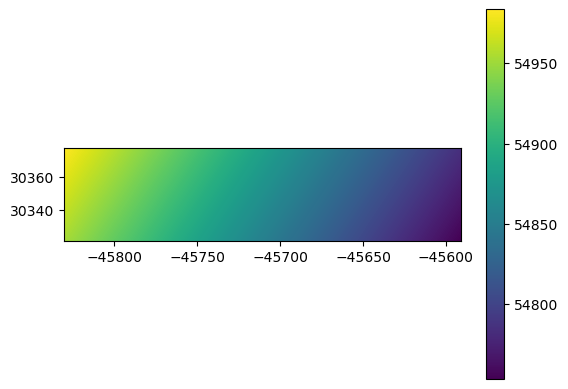

In [71]:
dist = 21.3 * 1000
plt.close()
x = dist*np.tan((wcs_coord[:,:,0]-RA0)/180*np.pi)
y = dist*np.tan((wcs_coord[:,:,1]-DEC0)/180*np.pi)
# plt.pcolormesh(x, y, hdu.data, norm=norm)
# plt.imshow(np.sqrt(x**2 + y**2))
im = plt.pcolormesh(x, y, np.sqrt(x**2 + y**2))
# plt.contour(x, y, np.sqrt(x**2 + y**2))
plt.colorbar(im)
plt.axis('scaled')
plt.show()

In [22]:
print(np.asarray(np.sqrt(x**2 + y**2)).shape)

(1187, 898)


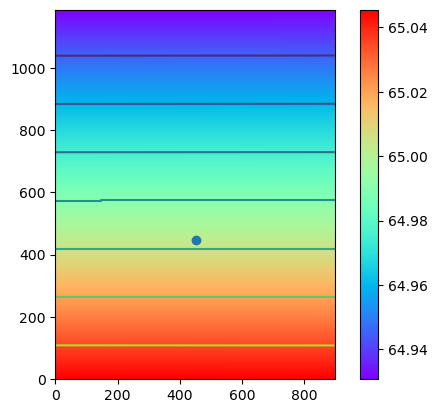

In [23]:
plt.close()
im = plt.imshow(wcs_coord[:,:,0], origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(wcs_coord[:, :, 0])
plt.colorbar(im)
plt.show()

In [24]:
wcs_coord[:,:, 0] = wcs_coord[:, :, 0] - RA0
wcs_coord[:,:, 1] = wcs_coord[:, :, 1] - DEC0

In [ ]:
# print(wcs_coord)

[[[ 0.04366323 -0.02484323]
  [ 0.04366317 -0.02478768]
  [ 0.0436631  -0.02473212]
  ...
  [ 0.04360927  0.02487897]
  [ 0.04360921  0.02493453]
  [ 0.04360915  0.02499008]]

 [[ 0.04356646 -0.02484327]
  [ 0.0435664  -0.02478771]
  [ 0.04356634 -0.02473215]
  ...
  [ 0.04351262  0.02487894]
  [ 0.04351256  0.02493449]
  [ 0.0435125   0.02499005]]

 [[ 0.04346969 -0.0248433 ]
  [ 0.04346963 -0.02478774]
  [ 0.04346957 -0.02473219]
  ...
  [ 0.04341597  0.0248789 ]
  [ 0.04341591  0.02493446]
  [ 0.04341585  0.02499002]]

 ...

 [[-0.07091046 -0.02483042]
  [-0.07091036 -0.02477487]
  [-0.07091026 -0.02471931]
  ...
  [-0.07082283  0.02489176]
  [-0.07082273  0.02494731]
  [-0.07082263  0.02500287]]

 [[-0.07100722 -0.02483037]
  [-0.07100713 -0.02477481]
  [-0.07100703 -0.02471926]
  ...
  [-0.07091948  0.02489181]
  [-0.07091938  0.02494737]
  [-0.07091928  0.02500292]]

 [[-0.07110399 -0.02483031]
  [-0.07110389 -0.02477476]
  [-0.0711038  -0.0247192 ]
  ...
  [-0.07101613  0.024891

In [25]:
distance_map = np.empty(shape=hdu.data.shape)
print(distance_map.shape)

(1187, 898)


In [29]:
i0 = hdu.header["CRPIX1"]
j0 = hdu.header["CRPIX2"]
print(i0, j0)

451.21399818598 447.31895706293


In [30]:
for i in range(wcs_coord.shape[0]):
    for j in range(wcs_coord.shape[1]):
        # distance_map[i, j] = np.sqrt(wcs_coord[i, j, 0]**2 + wcs_coord[i, j, 1]**2)
        distance_map[i, j] = np.sqrt((i-i0)**2 + (j-j0)**2)

In [31]:
print(wcs_coord[500, 500,:])

[-0.00471768  0.00292682]


In [32]:
print(distance_map[451, 447])

0.38409482109977455


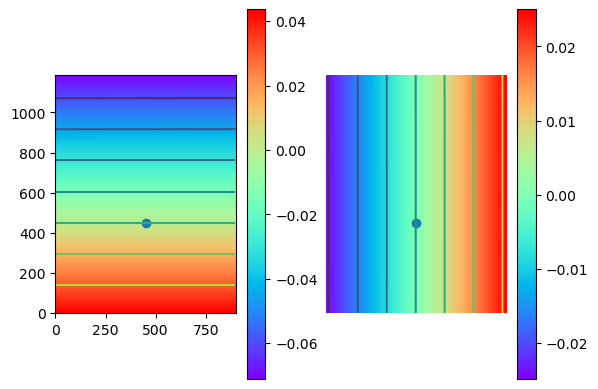

In [33]:
plt.subplot(121)
im = plt.imshow(wcs_coord[:, :, 0], origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(wcs_coord[:, :, 0])
plt.colorbar(im)

plt.subplot(122)
im = plt.imshow(wcs_coord[:, :, 1], origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(wcs_coord[:, :, 1])
plt.axis('off')
plt.colorbar(im)

plt.show()

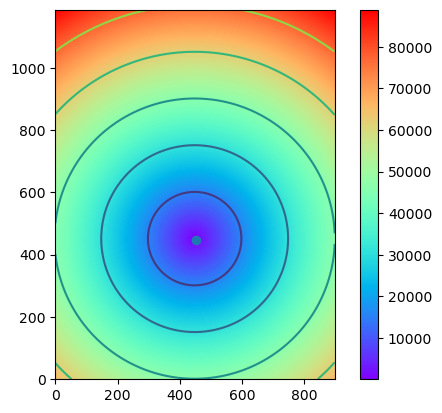

In [73]:
im = plt.imshow(dist*distance_map/206.265, origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(distance_map)
plt.colorbar(im)
plt.show()

(1187, 898)


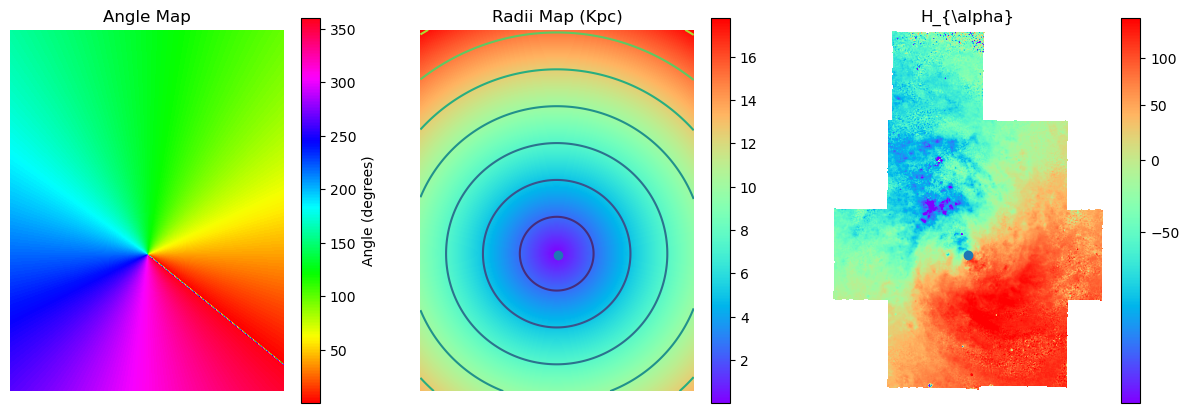

In [91]:
def create_angle_map(image_size, pa_deg, center_x, center_y):
    # Define the center of the image
    # center_x, center_y = image_size[0]//2, image_size[1]//2
    
    # Convert the position angle from degrees to radians
    pa_rad = np.radians(pa_deg)
    
    # Create a grid of coordinates for the image
    x = np.arange(image_size[1])
    y = np.arange(image_size[0])
    X, Y = np.meshgrid(x - center_x, y - center_y)  # Create coordinate grid centered at (0,0)
    
    # Calculate the angle for each pixel (in radians) relative to the center (0,0)
    angle_map = np.arctan2(Y, X)  # Angle in radians from the center
    
    # Adjust for the PA (rotate the angle to match the PA of the galaxy)
    angle_map += pa_rad - np.pi  # Apply the position angle offset
    
    # Normalize the angle to be within [0, 2π] range
    angle_map = np.mod(angle_map, 2 * np.pi)
    
    # Convert the angle map to degrees for easier interpretation
    angle_map_deg = np.degrees(angle_map)
    
    return angle_map_deg

# Parameters
shape = hdu.data.shape
print(shape)
image_size = shape
pa_deg = 219

# Create the angle map
angle_map = create_angle_map(image_size, pa_deg, hdu.header["CRPIX1"], hdu.header["CRPIX2"])

# Plot the angle map
plt.figure(figsize=[15, 5])
plt.subplot(131)
# fig.add_subplot(121, projection=wcs)
plt.imshow(angle_map, cmap='hsv', origin='lower')
plt.colorbar(label="Angle (degrees)")
plt.axis("off")
plt.title("Angle Map")

distance_map = dist*np.tan(distance_map*5.55555*10**(-5)*np.pi/180)
plt.subplot(132)
im = plt.imshow(distance_map, origin="lower", cmap="rainbow")
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.contour(distance_map)
plt.colorbar(im)
plt.axis("off")
plt.title("Radii Map (Kpc)")

plt.subplot(133)
im = plt.imshow(hdu.data, origin="lower", cmap="rainbow", norm = norm)
plt.scatter(hdu.header["CRPIX1"], hdu.header["CRPIX2"])
plt.colorbar(im)
plt.axis("off")
plt.title(r"H_{\alpha}")
plt.show()


In [ ]:

dataHa, hdr = fits.getdata("data/NGC1566_vel_Ha.fits", header=True)
dataS, _ = fits.getdata("data/NGC1566_vel_stars.fits", header=True)

norm = simple_norm(dataS, "sqrt", percent=99.)
normh = simple_norm(dataHa, "sqrt", percent=99.)
normm = simple_norm(dataHa-dataS, "sqrt", percent=99.)


In [ ]:
curve_rot = '''2.168284789644016; 149.28571428571425
4.239482200647252; 193.57142857142853
6.310679611650487; 198.57142857142853
8.31715210355987; 196.4285714285714
10.453074433656958; 194.99999999999994
12.45954692556634; 193.57142857142853
14.466019417475728; 190.71428571428567
16.601941747572813; 185.71428571428567
18.67313915857605; 179.28571428571425
20.679611650485437; 173.57142857142856
22.81553398058252; 172.1428571428571
24.88673139158576; 171.4285714285714
26.893203883495136; 172.1428571428571
29.02912621359223; 171.4285714285714
31.03559870550161; 167.1428571428571
33.042071197411005; 165.71428571428567
35.17799352750808; 164.99999999999997
37.24919093851132; 166.4285714285714
39.25566343042071; 173.57142857142856
41.391585760517785; 174.28571428571425
43.33333333333333; 171.4285714285714
45.404530744336554; 174.99999999999994
47.605177993527505; 169.99999999999994
49.61165048543688; 162.1428571428571'''


curve_rot = curve_rot.split('\n')
R = np.array([float(_.split(';')[0]) for _ in curve_rot])
V = np.array([float(_.split(';')[1]) for _ in curve_rot])

(0.0, 250.0)

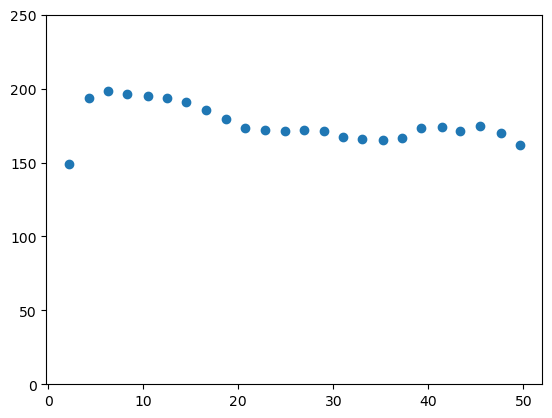

In [ ]:
plt.scatter(R, V)
plt.ylim([0, 250])

In [62]:
from scipy.interpolate import CubicSpline
# x = np.linspace(0, 10, num=11)
# y = np.cos(-x**2 / 9.)
spl = CubicSpline(R, V)

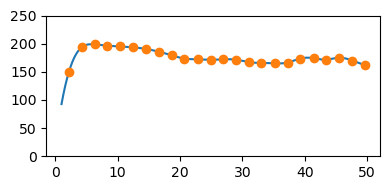

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 2))
xnew = np.linspace(1, R[-1], num=1001)
plt.plot(xnew, spl(xnew))
plt.plot(R, V, 'o', label='data')
plt.ylim([0, 250])

# ax[1].plot(xnew, spl(xnew, nu=1), '--', label='1st derivative')
# ax[2].plot(xnew, spl(xnew, nu=2), '--', label='2nd derivative')
# ax[3].plot(xnew, spl(xnew, nu=3), '--', label='3rd derivative')
# for j in range(4):
#     ax[j].legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
model_vel_map = np.empty(angle_map.shape)
incl = 31 
for i in range(model_vel_map.shape[0]):
    for j in range(model_vel_map.shape[1]):
        # print(f"spline = {spl(distance_map[i, j])}")
        model_vel_map[i, j] = spl(distance_map[i, j]/60)/np.sin(np.radians(incl))*np.cos(np.radians(angle_map[i, j]))


Text(0.5, 1.0, 'residial')

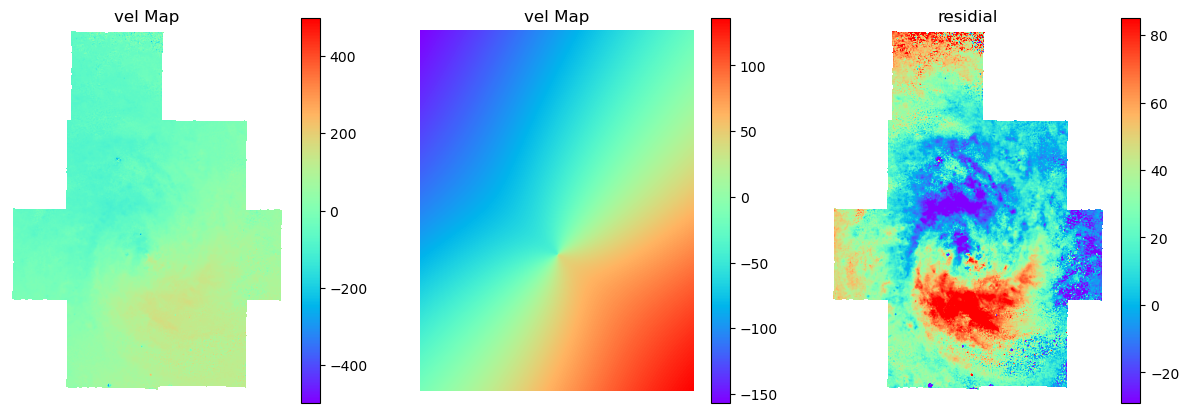

In [109]:
# Plot the model map
plt.figure(figsize=[15, 5])
plt.subplot(131)
# fig.add_subplot(121, projection=wcs)
norm=simple_norm(dataHa, "log", percent=95)
plt.imshow(dataHa, cmap='rainbow', origin='lower')
plt.colorbar()
plt.axis("off")
plt.title("vel Map")

plt.subplot(132)
# fig.add_subplot(121, projection=wcs)
plt.imshow(model_vel_map, cmap='rainbow', origin='lower')
plt.colorbar()
plt.axis("off")
plt.title("vel Map")


plt.subplot(133)
# fig.add_subplot(121, projection=wcs)
resid = dataHa - model_vel_map
norm = simple_norm(resid, "linear", percent=95)
plt.imshow(resid, cmap='rainbow', origin='lower', norm = norm)
plt.colorbar()
plt.axis("off")
plt.title("residial")

In [ ]:
! fitsheader "./data/NGC1566_vel_Ha.fits"

# HDU 0 in ./data/NGC1566_vel_Ha.fits:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  898                                                  
NAXIS2  =                 1187                                                  
CD1_1   = -5.5555555555556E-05                                                  
CD2_2   =  5.5555555555556E-05                                                  
CRVAL1  =    65.00184639371101                                                  
CRVAL2  =     -54.937912051515                                                  
CRPIX1  =      451.21399818598                                                  
CRPIX2  =      447.31895706293                                                  
CUNIT1  = 'deg     '                                                  

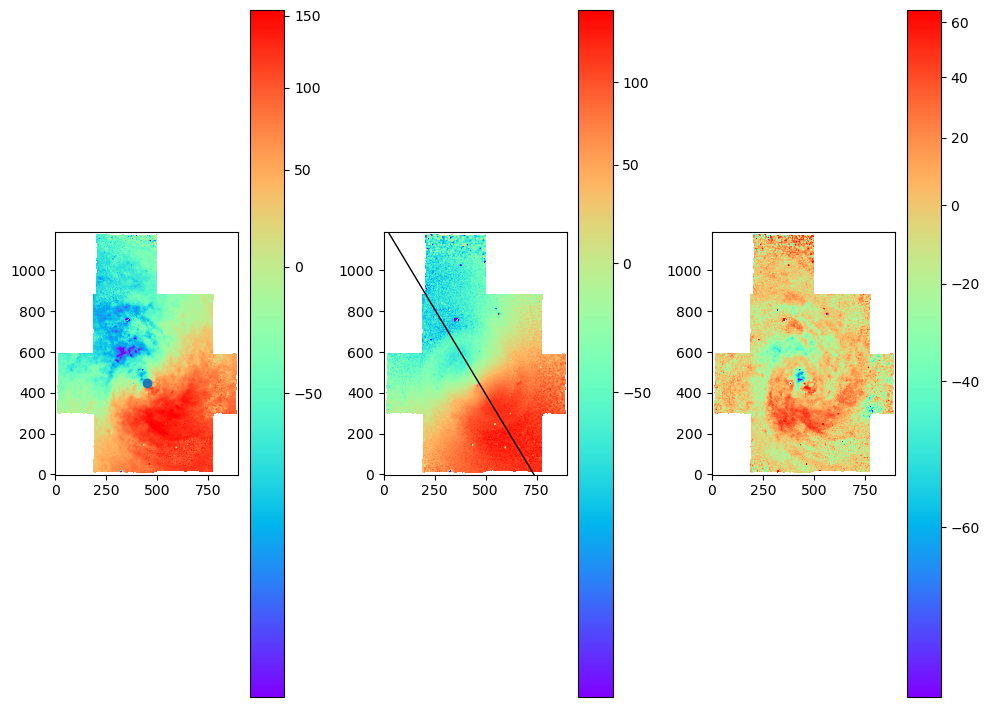

In [61]:
plt.close()
plt.figure(figsize=[10, 15])
plt.subplot(131)
im = plt.imshow(dataHa, cmap="rainbow", norm=normh, origin="lower")
plt.colorbar(im)
# plt.

plt.scatter(450, 450)

plt.subplot(132)
im = plt.imshow(dataS, cmap="rainbow", norm=norm, origin="lower")
plt.colorbar(im)
# plt.axline([450,450], color="white", linewidth=3, slope=1.664)
plt.axline([460,460], color="black", linewidth=1, slope=-1.664)


plt.subplot(133)
im = plt.imshow(dataHa-dataS, cmap="rainbow", norm=normm, origin="lower")
plt.colorbar(im)

plt.tight_layout()
plt.show()

In [ ]:
def calculate_intensity(image, popt):
    x0 = popt[1]
    y0 = popt[2]
    theta = np.tan(np.radians(popt[5]))
    n = 1000
    #xl = np.linspace(0, 499, 500)
    #yl = (xl - x0)/theta + y0
    #yll = -(xl - x0)*theta + y0

    int1 = np.empty(n)
    int2 = np.empty(n)

    for i in range(n):
        x = i/n*image.shape[0]
        y1 = -(x - x0)*theta + y0
        y2 = (x - x0)/theta + y0

        if (y1 > image.shape[1] or y1 < 0):
            int1[i] = 0
        else:
            int1[i] = image[int(x), int(y1)]

        if (y2 > image.shape[1] or y2 < 0):
            int2[i] = 0
        else:
            int2[i] = image[int(x), int(y2)]

    return int1, int2

In [ ]:
popt = [100, 450, 450, 0, 0, -45]

In [ ]:
a, b = calculate_intensity(dataHa, popt)

In [ ]:
x = np.where(dataHa==np.amax(dataHa[300:500, 300:500]))
print(x[1][40], x[0][40])
print(np.max(dataHa[300:500, 300:500]))

In [ ]:
plt.subplot(121)
plt.plot(dataHa[:,300])

plt.subplot(122)
plt.plot(dataHa[300,:])
plt.show()

In [ ]:
print(len(R))


24


In [ ]:
incl = 31
PA = 219

In [ ]:
phi = [i for i in range(360)]
# vel_map = np.zeros([len(R), len(phi)])

print(vel_map.shape)
# print(phi)


(24, 360)


In [ ]:
vel_map = np.zeros([len(R), 360])

vel_map[:,0] = V/np.sin(np.radians(incl))
print(vel_map[:,0])

for psi in range(360):
    vel_map[:, psi] = V/np.sin(np.radians(incl))*np.cos(np.radians(psi))
    # print(vel_map[:, psi])

[289.85374394 375.83906511 385.54708524 381.38650519 378.61278515
 375.83906511 370.29162504 360.5836049  348.10186473 337.00698458
 334.23326455 332.84640453 334.23326455 332.84640453 324.52524441
 321.75152438 320.36466436 323.1383844  337.00698458 338.3938446
 332.84640453 339.78070462 330.07268449 314.81722428]


In [ ]:
print(vel_map)

[ 3.34233265e+02  3.34182359e+02  3.34029659e+02  3.33775209e+02
  3.33419089e+02  3.32961406e+02  3.32402300e+02  3.31741940e+02
  3.30980529e+02  3.30118298e+02  3.29155510e+02  3.28092458e+02
  3.26929466e+02  3.25666888e+02  3.24305108e+02  3.22844542e+02
  3.21285635e+02  3.19628860e+02  3.17874724e+02  3.16023760e+02
  3.14076532e+02  3.12033634e+02  3.09895687e+02  3.07663342e+02
  3.05337281e+02  3.02918210e+02  3.00406868e+02  2.97804019e+02
  2.95110456e+02  2.92327000e+02  2.89454498e+02  2.86493825e+02
  2.83445884e+02  2.80311602e+02  2.77091934e+02  2.73787862e+02
  2.70400391e+02  2.66930554e+02  2.63379407e+02  2.59748032e+02
  2.56037535e+02  2.52249047e+02  2.48383721e+02  2.44442735e+02
  2.40427290e+02  2.36338608e+02  2.32177935e+02  2.27946538e+02
  2.23645707e+02  2.19276751e+02  2.14841001e+02  2.10339809e+02
  2.05774545e+02  2.01146600e+02  1.96457384e+02  1.91708325e+02
  1.86900870e+02  1.82036483e+02  1.77116646e+02  1.72142857e+02
  1.67116632e+02  1.62039

In [ ]:
vel_map = np.reshape(vel_map, [-1])
print(vel_map[:25])


[289.85374394 289.80959781 289.67717287 289.45650946 289.14767479
 288.75076294 288.26589481 287.69321809 287.03290723 286.28516337
 285.45021427 284.52831428 283.5197442  282.42481126 281.24384899
 279.97721712 278.62530148 277.18851387 275.66729195 274.0620991
 272.37342429 270.60178189 268.74771157 266.81177809 264.79457116]


In [ ]:
one = np.ones([24])
r = [R for i in range(360)]
phi = np.repeat([i for i in range(360)], 24)
# print(np.asarray(r).shape)
rr = np.reshape(np.asarray(r), [-1])
# phi = np.asarray([one*i for i in range(360)])
# r = np.repeat(R, 360)
# # print(np.asarray(r).shape)
# pphi = np.reshape(np.asarray(phi), [-1])
# rr = np.reshape(np.asarray(r), [-1])
# print(rr.shape)
# print(pphi.shape)
# print(vel_map[:25])
# np.radians(phi[100:120])

In [ ]:
def pol2cart(rho, phi):
    x = rho * np.cos(np.radians(phi))
    y = rho * np.sin(np.radians(phi))
    # print(f'x = {x}, y = {y}')
    return x, y


In [ ]:
# for i in range(24):
    # for j in range(360)

In [ ]:
x, y = pol2cart(rr, phi)
print(x.shape)
# print(x)
print(y.shape)
# print(y)

(8640,)
(8640,)


In [ ]:
x = np.reshape(x, [360, -1])
print(x.shape)
y = np.reshape(y, [360, -1])
vel_map = np.reshape(vel_map, [360, -1])
print(vel_map.shape)
x

(360, 24)
(360, 24)


array([[ 2.16828479,  4.2394822 ,  6.31067961, ..., 45.40453074,
        47.60517799, 49.61165049],
       [ 2.16795455,  4.23883651,  6.30971846, ..., 45.39761541,
        47.59792749, 49.60409439],
       [ 2.16696393,  4.23689962,  6.30683532, ..., 45.37687153,
        47.57617821, 49.58142841],
       ...,
       [ 2.16531323,  4.23367214,  6.30203104, ..., 45.34230541,
        47.53993675, 49.54365944],
       [ 2.16696393,  4.23689962,  6.30683532, ..., 45.37687153,
        47.57617821, 49.58142841],
       [ 2.16795455,  4.23883651,  6.30971846, ..., 45.39761541,
        47.59792749, 49.60409439]])

In [ ]:
print(x[80, :])
print(y[80, :])
print(vel_map[80, :])

[2.16357762 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762
 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762
 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762
 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762 2.16357762]
[12.27025841 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841
 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841
 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841
 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841 12.27025841]
[-187.91953256 -193.57142857 -199.16436085 -204.69662574 -210.16653806
 -215.57243161 -220.91265971 -226.18559567 -231.38963331 -236.52318743
 -241.58469429 -246.57261211 -251.48542153 -256.32162605 -261.07975253
 -265.75835158 -270.35599806 -274.87129148 -279.30285645 -283.64934306
 -287.90942734 -292.08181161 -296.16522493 -300.15842346]


TypeError: pcolormesh() takes 1 or 3 positional arguments but 2 were given

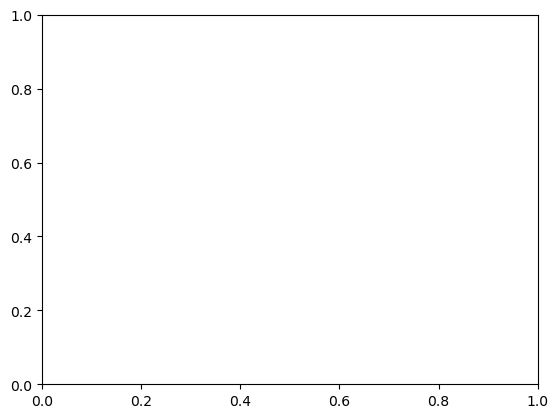

In [ ]:
plt.close()
im = plt.pcolormesh(x, y)
plt.colorbar(im)
plt.show()

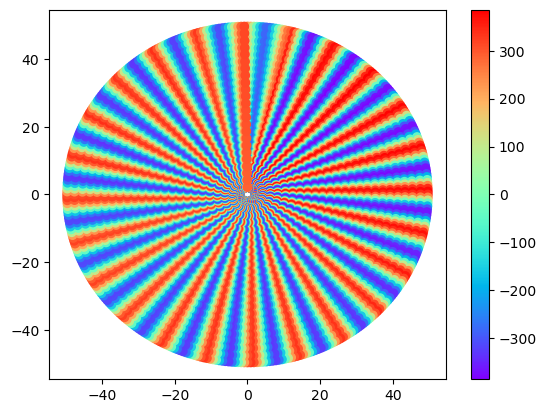

In [ ]:
# plt.pcolormesh(x, y, vel_map)
plt.close()
im = plt.scatter(y, x, c=vel_map, cmap="rainbow")
plt.colorbar(im)
plt.show()

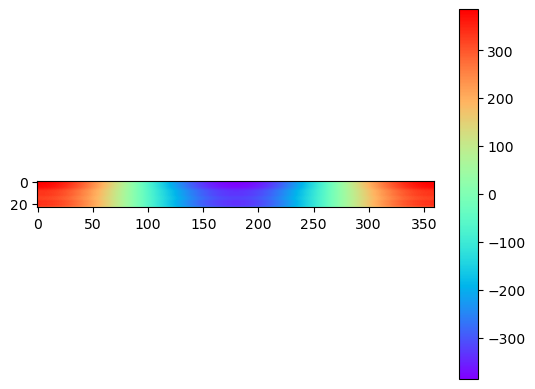

In [ ]:
im = plt.imshow(vel_map, cmap="rainbow")
plt.colorbar(im)
plt.show()

In [ ]:
vel_map.shape[0]

24

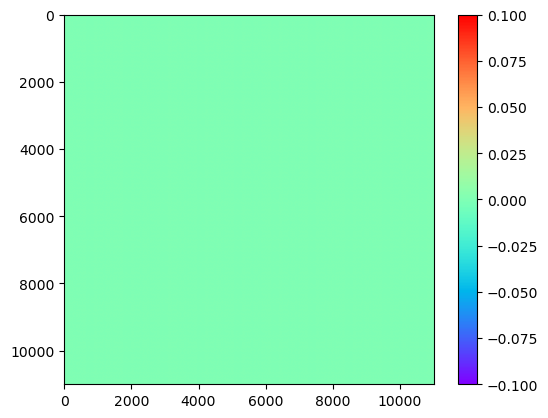

In [ ]:
vel_map_xy = np.zeros([11000, 11000])
im = plt.imshow(vel_map_xy, cmap="rainbow")
plt.colorbar(im)
plt.show()


In [ ]:
R

In [ ]:

for i in range(len(R)):
    for j in range(vel_map.shape[1]):
        x, y = pol2cart(R[i], np.radians(j))
        # print(vel_map[i, j])
        # print(x, y)
        if (vel_map_xy[int(x*100)+5000, int(y*100)+5000] == 0.):
            vel_map_xy[int(x*100)+5000, int(y*100)+5000] = vel_map[i, j]
            # print(vel_map_xy[int(x*100)+5000, int(y*100)+5000] )
        # print(vel_map_xy[100, 1000])
        print(int(x*100)+5000, int(y*100)+5000)

5216 5000
5216 5003
5216 5007
5216 5011
5216 5015
5216 5018
5215 5022
5215 5026
5214 5030
5214 5033
5213 5037
5212 5041
5212 5045
5211 5048
5210 5052
5209 5056
5208 5059
5207 5063
5206 5067
5205 5070
5203 5074
5202 5077
5201 5081
5199 5084
5198 5088
5196 5091
5194 5095
5193 5098
5191 5101
5189 5105
5187 5108
5185 5111
5183 5114
5181 5118
5179 5121
5177 5124
5175 5127
5173 5130
5170 5133
5168 5136
5166 5139
5163 5142
5161 5145
5158 5147
5155 5150
5153 5153
5150 5155
5147 5158
5145 5161
5142 5163
5139 5166
5136 5168
5133 5170
5130 5173
5127 5175
5124 5177
5121 5179
5118 5181
5114 5183
5111 5185
5108 5187
5105 5189
5101 5191
5098 5193
5095 5194
5091 5196
5088 5198
5084 5199
5081 5201
5077 5202
5074 5203
5070 5205
5067 5206
5063 5207
5059 5208
5056 5209
5052 5210
5048 5211
5045 5212
5041 5212
5037 5213
5033 5214
5030 5214
5026 5215
5022 5215
5018 5216
5015 5216
5011 5216
5007 5216
5003 5216
5000 5216
4997 5216
4993 5216
4989 5216
4985 5216
4982 5216
4978 5215
4974 5215
4970 5214
4967 5214


In [ ]:
colors = ['r', 'g', 'b', 'm', 'y']

In [ ]:
for rad in range(vel_map.shape[1]):
    for ro in range(len(R)):
        clr = "w"
        where_color = vel_map[ro, rad]
        if where_color>0 :
            if where_color<70:
                clr = colors[1]
            elif where_color < 180:
                clr = "y"
            elif where_color < 400:
                clr = 'r'

        else:
            if where_color>-70:
                clr = colors[1]
            elif where_color > -180:
                clr = 'm'
            elif where_color>-400:
                clr = 'b'

            
        print(where_color)
        print(clr)
        plt.polar(rad*np.pi/180, ro, color=clr)

plt.show()

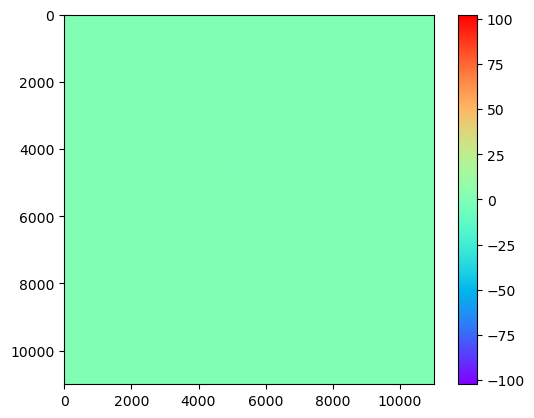

In [ ]:
im = plt.imshow(vel_map_xy, cmap="rainbow")
plt.colorbar(im)
plt.show()

In [ ]:
! fitsheader "data/NGC1566_vel_Ha.fits"